In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import seaborn as sns
import shap
sns.set(style="white")

### Data Preparation & EDA

In [2]:
# import data
df = pd.read_csv('data/churn_data.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# clean up column names
df.columns = df.columns.str.replace(' ', '_')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account_length            3333 non-null int64
area_code                 3333 non-null int64
phone_number              3333 non-null object
international_plan        3333 non-null object
voice_mail_plan           3333 non-null object
number_vmail_messages     3333 non-null int64
total_day_minutes         3333 non-null float64
total_day_calls           3333 non-null int64
total_day_charge          3333 non-null float64
total_eve_minutes         3333 non-null float64
total_eve_calls           3333 non-null int64
total_eve_charge          3333 non-null float64
total_night_minutes       3333 non-null float64
total_night_calls         3333 non-null int64
total_night_charge        3333 non-null float64
total_intl_minutes        3333 non-null float64
total_intl_calls          3333 non-null int64
total_intl_charge         3333 non-null float64

In [5]:
# Change data types to 'category' and change yes/no to 1 or 0
df['state'] = df['state'].astype('category')
df['international_plan'] = df['international_plan'].replace(('yes', 'no'), (1, 0))
df['international_plan'] = df['international_plan'].astype('int')
df['voice_mail_plan'] = df['voice_mail_plan'].replace(('yes', 'no'), (1, 0))
df['voice_mail_plan'] = df['voice_mail_plan'].astype('int')
df['churn'] = df['churn'].replace((True, False), (1, 0))
df['churn'] = df['churn'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null category
account_length            3333 non-null int64
area_code                 3333 non-null int64
phone_number              3333 non-null object
international_plan        3333 non-null int32
voice_mail_plan           3333 non-null int32
number_vmail_messages     3333 non-null int64
total_day_minutes         3333 non-null float64
total_day_calls           3333 non-null int64
total_day_charge          3333 non-null float64
total_eve_minutes         3333 non-null float64
total_eve_calls           3333 non-null int64
total_eve_charge          3333 non-null float64
total_night_minutes       3333 non-null float64
total_night_calls         3333 non-null int64
total_night_charge        3333 non-null float64
total_intl_minutes        3333 non-null float64
total_intl_calls          3333 non-null int64
total_intl_charge         3333 non-null float64

In [6]:
# Count no. of churns per state for map below
df_statechurns = df[['state','churn']]
df_statechurns = df_statechurns.groupby(['state'], as_index=False).sum()
df_statechurns.head(3)

,state,churn
0,AK,3
1,AL,8
2,AR,11


In [7]:
# Create map of churns per state to see if any visual patterns
url = (
    'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
)
state_geo = f'{url}/us-states.json'
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_statechurns,
    columns=['state', 'churn'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Churn Count',
).add_to(m)

folium.LayerControl().add_to(m)
m.save('images/map.html')
m


It looks like there may be some trends, however to avoid creating a dummy column for each of 50 states, categorize each into one of 4 regions as defined by the US Census Bureau.

In [8]:
# import data for states and their regions
df_regions = pd.read_csv('data/state-geocodes.csv')
df_regions.head()

,Region,RegionName,Division,State (FIPS),StateName,StateCode
0,3,South,6,1,Alabama,AL
1,4,West,9,2,Alaska,AK
2,4,West,8,4,Arizona,AZ
3,3,South,7,5,Arkansas,AR
4,4,West,9,6,California,CA


In [9]:
# Drop unnecessary columns and rename columns
df_regions = df_regions.drop(columns=['Region', 'Division', 'State (FIPS)', 'StateName'])
df_regions = df_regions.rename({'StateCode': 'state', 'RegionName': 'region'}, axis=1)
df_regions['state'] = df_regions['state'].astype('category')
df_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
region    51 non-null object
state     51 non-null category
dtypes: category(1), object(1)
memory usage: 3.5+ KB


In [10]:
# Merge region data with original data
df = df.merge(df_regions, on='state', how='left')

In [11]:
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,region
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,Midwest
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,16.62,254.4,103,11.45,13.7,3,3.70,1,0,Midwest
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,10.30,162.6,104,7.32,12.2,5,3.29,0,0,Northeast
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,5.26,196.9,89,8.86,6.6,7,1.78,2,0,Midwest
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,12.61,186.9,121,8.41,10.1,3,2.73,3,0,South


In [12]:
# create region dummies
region = pd.get_dummies(df['region'], prefix='region', drop_first=True)
df = df.join(region)
df.drop(['region'], axis=1, inplace=True)
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,region_Northeast,region_South,region_West
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,91,11.01,10.0,3,2.70,1,0,0,0,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,11.45,13.7,3,3.70,1,0,0,0,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,104,7.32,12.2,5,3.29,0,0,1,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,89,8.86,6.6,7,1.78,2,0,0,0,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,121,8.41,10.1,3,2.73,3,0,0,1,0


### Model 1 - Logistic Regression - SKlearn

In [13]:
# Create independent and dependent sets
y = df['churn']

# drop y column 'churn' and phone number
# drop state and area code in favor of region column
X = df.drop(columns=['churn', 'phone_number', 'state', 'area_code'], axis=1)
columns = X.columns

In [14]:
# Create test and train splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [15]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_np = norm.transform(X_train) # creates a numpy array
X_train = pd.DataFrame(X_train_np, columns=columns) # convert back to dataframe

# transform testing data using X_train scale
X_test_np = norm.transform(X_test)
X_test = pd.DataFrame(X_test_np, columns=columns)

In [16]:
# Create the model
logreg = LogisticRegression(random_state=42)

# Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [17]:
# Generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [18]:
# Caclulate accuracy and AUC for train data
accuracy = accuracy_score(y_train, y_hat_train)
print('Train Accuracy is: {0}'.format(round(accuracy, 2)))

# Calculate accuracy and AUC for test data
accuracy = accuracy_score(y_test, y_hat_test)
print('Test Accuracy is: {0}'.format(round(accuracy, 3)))

Train Accuracy is: 0.86
Test Accuracy is: 0.864


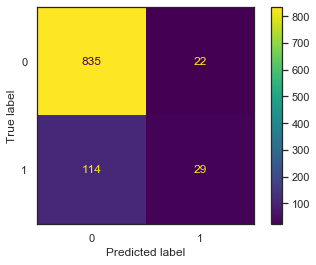

In [19]:
# Look at confusion matrix
plot_confusion_matrix(logreg, X_test, y_test)
plt.show()

In [20]:
# Calculate Recall
recall = recall_score(y_test, y_hat_test)
print('Recall: {:.4}%'.format(recall * 100))

Recall: 20.28%


In [21]:
# Classes imbalanced--use Precision-Recall Curves instead ROC curve
def pr_curve(model):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    y_hat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)
    # summarize scores
    print('f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Recall vs. Precision')
    # show the legend
    plt.legend()

f1=0.299 auc=0.446


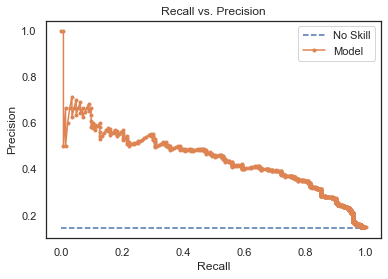

In [22]:
# Precision-Recall Curves for Logistic Regression Tree
pr_curve(logreg)
# save plot
plt.savefig('images/pr_curve_lr.png', dpi=150)
# show the plot
plt.show()

Recall is 20.28%. Try to find an optimal C value.

### Model 1b - Logistic Regression - Optimized

In [23]:
# Find the best C value for logistic regression
C = [100, 10, 1, .1, .001]
for c in C:
    logmodel = LogisticRegression(C=c)
    logmodel.fit(X_train, y_train)
    print('C:', c)
    print('Training accuracy:', logmodel.score(X_train, y_train))
    print('Test accuracy:', logmodel.score(X_test, y_test))
    print('')

C: 100
Training accuracy: 0.8598371195885126
Test accuracy: 0.863

C: 10
Training accuracy: 0.8602657522503214
Test accuracy: 0.864

C: 1
Training accuracy: 0.8611230175739392
Test accuracy: 0.864

C: 0.1
Training accuracy: 0.8602657522503214
Test accuracy: 0.86

C: 0.001
Training accuracy: 0.8542648949849978
Test accuracy: 0.857



In [24]:
# Fit the model using the best C value from above
logmodel = LogisticRegression(C=100)
logmodel.fit(X_train, y_train)

# Generate predictions
y_hat_train = logmodel.predict(X_train)
y_hat_test = logmodel.predict(X_test)

In [25]:
# Caclulate accuracy and AUC for train data
accuracy = accuracy_score(y_train, y_hat_train)
print('Train Accuracy is: {0}'.format(round(accuracy, 2)))

# Calculate accuracy and AUC for test data
accuracy = accuracy_score(y_test, y_hat_test)
print('Test Accuracy is: {0}'.format(round(accuracy, 3)))

Train Accuracy is: 0.86
Test Accuracy is: 0.863


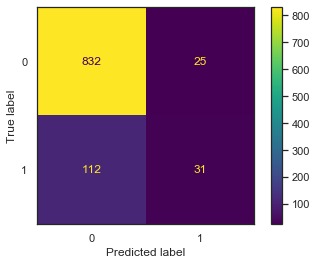

In [26]:
# Plot confusion matrix
plot_confusion_matrix(logmodel, X_test, y_test)
plt.show()

In [27]:
# Calculate Recall
recall = recall_score(y_test, y_hat_test)
print('Recall: {:.4}%'.format(recall * 100))

Recall: 21.68%


f1=0.312 auc=0.450


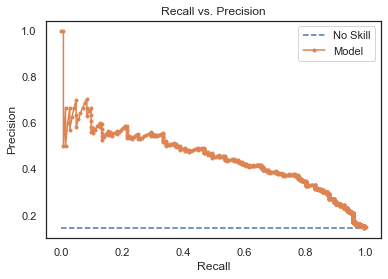

In [60]:
# Precision-Recall Curves for Logistic Regression Tree
pr_curve(logmodel)
# save plot
plt.savefig('images/pr_curve_lr.png', dpi=150)
# show the plot
plt.show()

Recall slightly better at 21.68%, so time to try a different classifier.

### Model 2 - Decision Tree Classifier via Gini

In [29]:
# Train a DT classifier
classifier = DecisionTreeClassifier(random_state=10)  
classifier.fit(X_train, y_train) 

DecisionTreeClassifier(random_state=10)

In [30]:
# Make predictions for test data
y_hat_train = classifier.predict(X_train) 

# Make predictions for test data
y_pred = classifier.predict(X_test) 

In [31]:
# Caclulate accuracy and AUC for test data
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy is: {0}'.format(round(accuracy, 3)))

# Check the AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is: {0}'.format(round(roc_auc, 3)))

Accuracy is: 0.915

AUC is: 0.834


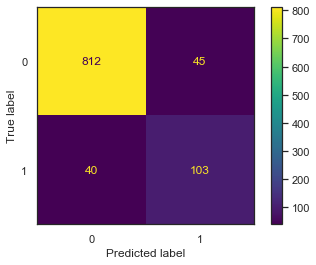

In [32]:
# Look at confusion matrix
plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

In [33]:
# Calculate Recall
recall = recall_score(y_test, classifier.predict(X_test))
print('Recall: {:.4}%'.format(recall * 100))

Recall: 72.03%


f1=0.708 auc=0.728


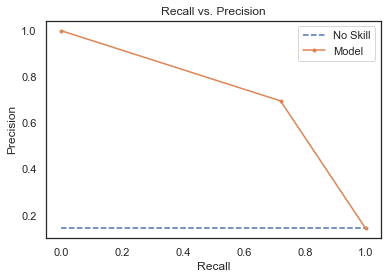

In [34]:
# Precision-Recall Curves for Gini Tree
pr_curve(classifier)
# save plot
plt.savefig('images/pr_curve_dt_gini.png', dpi=150)
# show the plot
plt.show()

Still improving with recall of 72.03%. See if we can improve the decision tree even further. 

### Model 2b - Decision Tree Classifier via Entropy

In [35]:
# Use entropy
classifier_2 = DecisionTreeClassifier(random_state=10, criterion='entropy')  
classifier_2.fit(X_train, y_train)

# Make predictions for test data
y_pred = classifier_2.predict(X_test) 

In [36]:
# Make predictions for test data
y_hat_train = classifier_2.predict(X_train) 

# Make predictions for test data
y_pred = classifier_2.predict(X_test) 

In [37]:
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred)
print('Accuracy is :{0}'.format(round(acc, 3)))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 3)))

Accuracy is :0.931

AUC is :0.84


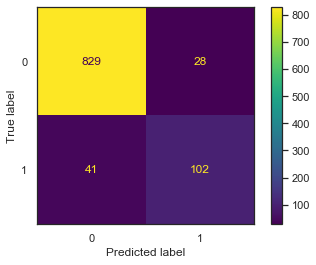

In [38]:
# Look at confusion matrix
plot_confusion_matrix(classifier_2, X_test, y_test)
plt.show()

In [39]:
# Calculate Recall
recall = recall_score(y_test, y_pred)
print('Recall: {:.4}%'.format(recall * 100))

Recall: 71.33%


f1=0.747 auc=0.769


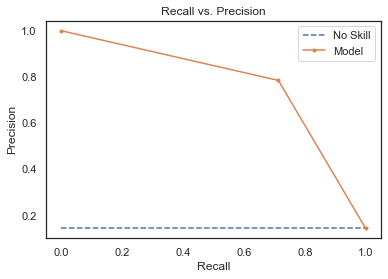

In [40]:
# Precision-Recall Curves for Entropy Tree
pr_curve(classifier_2)
# save plot
plt.savefig('images/pr_curve_dt_entropy.png', dpi=150)
# show the plot
plt.show()

### Model 3 - XG Boost

In [41]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 96.79%
Validation accuracy: 95.3%


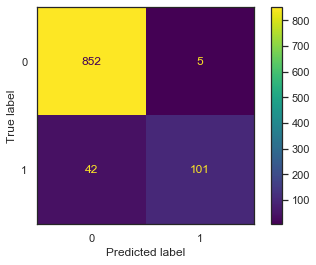

In [42]:
# Look at confusion matrix
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

In [43]:
# Calculate Recall
recall = recall_score(y_test, test_preds) *100
print('Recall: {:.4}%'.format(recall))

Recall: 70.63%


f1=0.811 auc=0.886


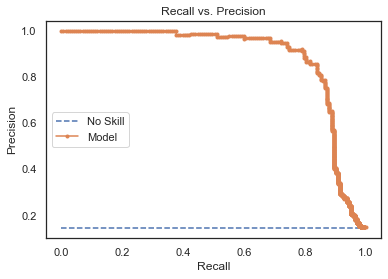

In [44]:
# Precision-Recall Curves for XGBoost
pr_curve(clf)
# save plot
plt.savefig('images/pr_curve_xgboost.png', dpi=150)
# show the plot
plt.show()

### Model 3b - Grid Search

In [45]:
# Goal is to increase recall
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [10, 20],
    'scale_pos_weight': [5] # impose greater penalties for errors on the minor class, sum(negative instances) / sum(positive instances)
}

In [46]:
# Grid Search based on previous XG Boost classifier
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', 
                        cv=None, n_jobs=1)

grid_clf.fit(X_train, y_train)
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
grid_clf
print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 4
min_child_weight: 1
n_estimators: 20
scale_pos_weight: 5
subsample: 0.5

Training Accuracy: 95.54%
Validation accuracy: 95.1%


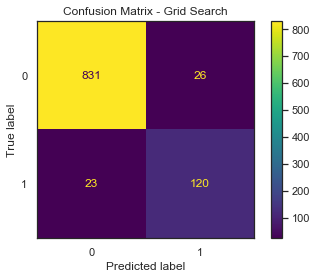

In [47]:
# Look at confusion matrix
plot_confusion_matrix(grid_clf, X_test, y_test)
plt.title('Confusion Matrix - Grid Search')

# save plot
plt.savefig('images/conf_matrix_gridsearch.png', dpi=150)

plt.show()

In [48]:
# Calculate Recall
recall = recall_score(y_test, test_preds) 
print('Recall: {:.4}%'.format(recall * 100))

Recall: 83.92%


f1=0.830 auc=0.873


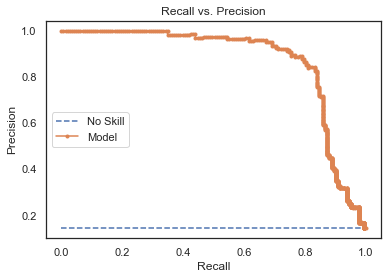

In [49]:
# Precision-Recall Curves for Grid Search
pr_curve(grid_clf)
# save plot
plt.savefig('images/pr_curve_gridsearch.png', dpi=150)
# show the plot
plt.show()

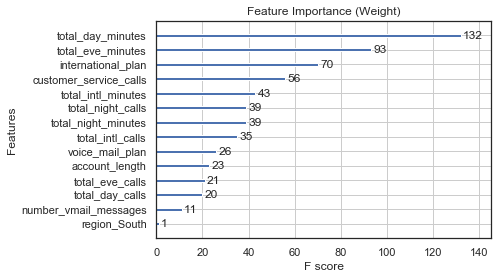

In [50]:
# plot feature importance
plot_importance(clf, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

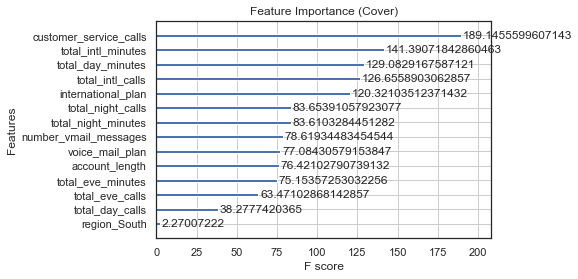

In [51]:
plot_importance(clf, importance_type='cover')
plt.title('Feature Importance (Cover)')
plt.show()

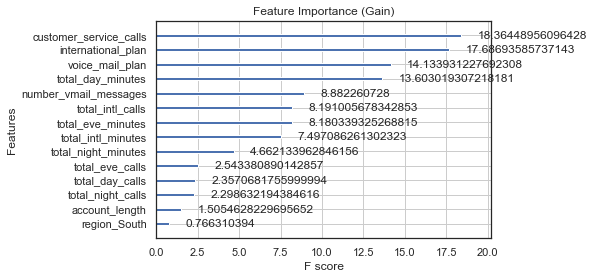

In [52]:
plot_importance(clf, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()

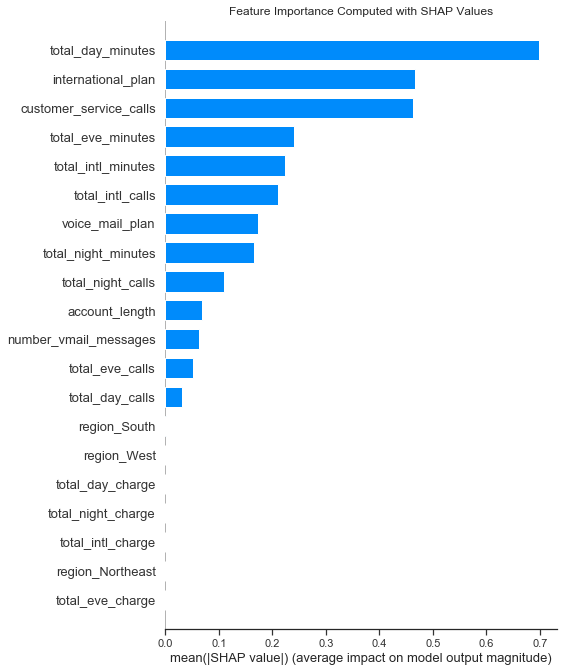

In [53]:
# Feature Importance Computed with SHAP Values (Game Theory)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Feature Importance Computed with SHAP Values')
plt.tight_layout()
# save plot
plt.savefig('images/shap_importance.png', dpi=300)
plt.show()

In [54]:
# split data into customers that stayed or churned
yes_churn = df[df['churn']==1]
no_churn = df[df['churn']==0]

No Churn Median: 177.2 mins
No Churn Mean: 175.2 mins
Churn Median: 217.6 mins
Churn Mean: 206.9 mins


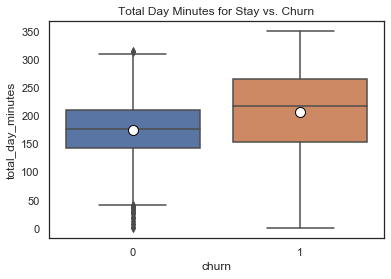

In [55]:
# Look at boxplot for total day minutes 
bp = sns.boxplot(x='churn', y='total_day_minutes', data=df, 
                 showmeans=True,
                 meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
bp.set_title('Total Day Minutes for Stay vs. Churn')

print('No Churn Median: {:.4} mins'.format(no_churn['total_day_minutes'].median()))
print('No Churn Mean: {:.4} mins'.format(no_churn['total_day_minutes'].mean()))

print('Churn Median: {:.4} mins'.format(yes_churn['total_day_minutes'].median()))
print('Churn Mean: {:.4} mins'.format(yes_churn['total_day_minutes'].mean()))

# save plot
plt.savefig('images/boxplot_day_minutes.png', dpi=150)

plt.show()

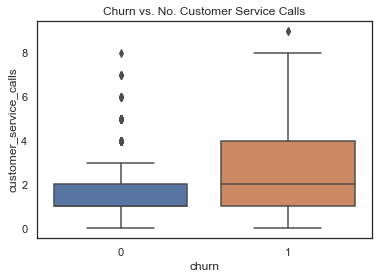

In [56]:
bp = sns.boxplot(x='churn', y='customer_service_calls', data=df)
bp.set_title('Churn vs. No. Customer Service Calls')

# save plot
plt.savefig('images/boxplot_no_service_calls.png', dpi=150)

plt.show()

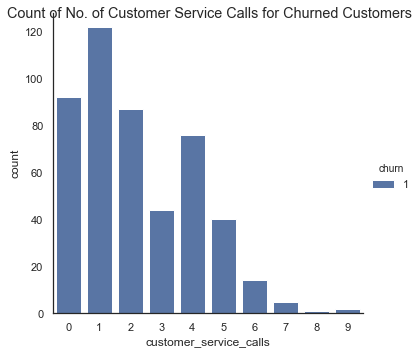

In [57]:
ax = sns.catplot(x="customer_service_calls", hue="churn", data=yes_churn, kind="count")
ax.fig.suptitle('Count of No. of Customer Service Calls for Churned Customers')

# save plot
plt.savefig('images/bar_service_calls.png', dpi=150)

plt.show()

No Churn with Plan: 186 customers
No Churn wout Plan: 2664 customers
Churn with Plan: 137 customers
Churn wout Plan: 297 customers


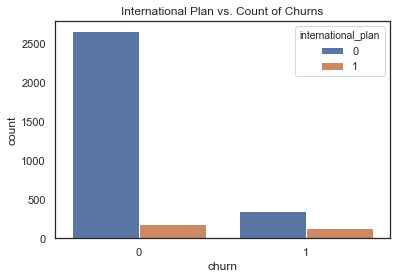

In [58]:
ax = sns.countplot(x="churn", hue="international_plan", data=df)
ax.set_title('International Plan vs. Count of Churns')

# save plot
plt.savefig('images/bar_intl_plan.png', dpi=150)

print('No Churn with Plan: {} customers'.format(no_churn['international_plan'].sum()))
print('No Churn wout Plan: {} customers'.format(no_churn['international_plan'].count()-no_churn['international_plan'].sum()))
print('Churn with Plan: {} customers'.format(yes_churn['international_plan'].sum()))
print('Churn wout Plan: {} customers'.format(yes_churn['international_plan'].count()-no_churn['international_plan'].sum()))

plt.show()

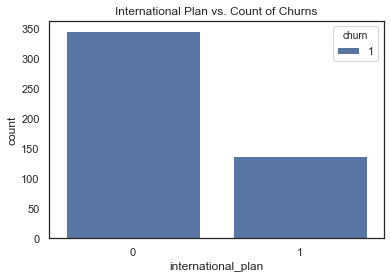

In [59]:
ax = sns.countplot(x="international_plan", hue="churn", data=yes_churn)
ax.set_title('International Plan vs. Count of Churns')

# save plot
plt.savefig('images/bar_intl_plan_churns.png', dpi=150)

plt.show()